<a href="https://www.kaggle.com/code/isissantoscosta/create-database-from-sql-file-sqlite?scriptVersionId=240768885" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a id='top'></a>
Created on May 19, 2025 • by [Ísis Santos Costa](https://www.linkedin.com/in/isis-santos-costa/)

<hr>

**How to create a database from a `.sql` file?**

There are clearly myriad answers to this question. As someone working primarily with cloud environments, mainly on GCP, my first go was to load the `.sql` file to a bucket on Cloud Storage[🔗](https://cloud.google.com/storage) and run it on Cloud Run[🔗](https://cloud.google.com/run) to build a MySQL database on Cloud SQL[🔗](https://cloud.google.com/sql). The purpose was to [delve deep into **365 Data Science • Practice Exams: SQL**](https://www.kaggle.com/code/isissantoscosta/365ds-practice-exams-sql/), for which the estimated cloud costs would suit a thrifty approach. An incident of not _remembering to STOP the instance_[🔗](#remember), though, led to the procedure presented in this notebook, from wondering:

_Is there a free a alternative to only get the dataset into a CSV, from DDL statements in a SQL file?_

<hr>

<center>
    <img src='https://raw.githubusercontent.com/isis-santos-costa/utils/refs/heads/main/img/databases.jpg' alt='databases' width='350'>
    <figcaption>
        License-free illustration by 
        <a href='https://www.freepik.com/author/juicy-fish'>juicy-fish</a> 
        via 
        <a href='https://www.freepik.com/'>Freepik</a>
    </figcaption>
</center>

<a id='create'></a>

# <div style="background-color:#03002e; padding:18px; border-radius:8px; color:white; text-align:center; font-weight:regular; overflow:hidden"><strong>Create a SQLite database</strong></div>

[SQLite](https://www.sqlite.org/) is a unique database engine that **stores** the whole schema and all the corresponding records **in a single file**.  If you have been using databases such as MySQL, SQL Server, Oracle for a while and, as was the case for me, have never heard of it before, the following info may surprise you:  
<br>

> **SQLite is the most used database engine in the world** [🔗](https://www.sqlite.org/mostdeployed.html)

<br>

The impressive reach is explained by its small size and ease of use making SQLite a popular choice for embedded systems, mobile applications, and web browsers.  
<br>

---

<br>

Back to our case, in which we have a `.sql` DDL file and want to extract the corresponding dataset as a set of CSV files, SQLite enables us to do the job with zero configuration, no installations required. With SQLite, the task of **« Create a database from `.sql` file »** simply translates to **« Generate a `.db` file »**, which is performed in the next two cells.

First, in the cell right below, the `.sql` file that contains the data used on the [365 Data Science • Practice Exams: SQL](https://learn.365datascience.com/exams/?tab=practice) is imported from the [employees-dataset](https://www.kaggle.com/datasets/huzaifamirza/employees-dataset), where the mentioned data has already been made available by [Mirza Huzaifa](https://www.kaggle.com/huzaifamirza) on Kaggle.  


Then, in the subsequent cell, the **[sqlite3](https://docs.python.org/3/library/sqlite3.html)** module is imported, and applied in executing the SQL DDL script, resulting in building the database, thus: writing a `employees.db` file.  

Given that in SQLite the generated `.db` file _is_ the database itself, commands like `CREATE DATABASE` are not supported. In addition, since the views from the original file can be easily created from the tables, and the focus here is on building and populating these tables, the SQL script is first reduced to keep only its `CREATE TABLE` and `INSERT INTO` statements.

A further preparation step is related to syntax: as it is the case for SQL dialect compatibility, in general, some SQLite expressions are not implemented in the exact way as on MySQL, dialect of the original `.sql` file. Specifically, for the chosen script, the following **SQL dialect translations** had to be performed:  

• MySQL `UNIQUE KEY`  
↳ SQLite `UNIQUE`  

• MySQL `gender   ENUM ('M','F')   NOT NULL,`  
↳ SQLite `gender   TEXT CHECK( gender IN ('M','F') )   NOT NULL DEFAULT 'M',`

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/employees-dataset/Employees Dataset.sql


In [2]:
# Create a SQLite database: Generate a .db file from a DDL .sql file

# Notice that SQLite does not support DATABASE creation/call statements.
# In addition, the purpose here is to create a dataset, from which the views seen on the original file can be created again.
# For this reason, only the 'CREATE TABLE' and 'INSERT INTO' statements are extracted from the original DDL.

import sqlite3
import re

def replace_enum_with_sqlite_check(sql_script):
    """
    On the column definition of a SQL code, converts MySQL ENUM style into its SQLite equivalent.
    The first item in the ENUM list is set as default.

    Args:
        sql_script (str): The SQL code to have ENUM converted into SQLite style.
    """
    def replace_match(match):
        column_name = match.group(1).strip()
        enum_values_str = match.group(2).strip()
        enum_values_list = [v.strip().strip("'") for v in enum_values_str.split(',')]
        sqlite_check = f"TEXT CHECK( {column_name} IN ({enum_values_str}) )"
        default_value = f"DEFAULT '{enum_values_list[0]}'" if enum_values_list else ""
        return f"{column_name}   TEXT {sqlite_check}   NOT NULL {default_value},"

    pattern = r"(?i)(\w+)\s+ENUM\s*\(([^)]+)\)\s+NOT NULL,?"
    modified_script = [re.sub(pattern, replace_match, s) for s in sql_script]
    return modified_script

# Example usage:
mysql_style  = "gender   ENUM ('M','F')   NOT NULL,"
sqlite_style = "gender      TEXT CHECK( gender IN ('M','F') )   NOT NULL DEFAULT 'M',"


def create_db_from_sql(sql_filepath, db_filepath):
    """
    Creates a SQLite database file from an SQL file.

    Args:
        sql_filepath (str): The path to the SQL file.
         db_filepath (str): The path to the output database file.
    """
    try:
        connection = sqlite3.connect(db_filepath)
        cursor = connection.cursor()
        
        with open(sql_filepath, 'r') as sql_file:
            sql_script = sql_file.read()

        # Get CREATE TABLE, DROP TABLE, INSERT INTO statements from the .sql file
        pattern  = r"(?is)CREATE\s+TABLE\s+[^;]+;"
        pattern +=      r"|INSERT\s+INTO\s+[^;]+;"
        sql_script = re.findall(pattern, sql_script)        
        
        # Replace MySQL ENUM by SQLite style
        sql_script = replace_enum_with_sqlite_check(sql_script)

        # Replace MySQL UNIQUE KEY by SQLite style
        mysql_style  = "UNIQUE  KEY"
        sqlite_style = "UNIQUE"
        sql_script = [s.replace(mysql_style, sqlite_style) for s in sql_script]

        # # 🚧 Modular troubleshooting (applicable when developing/testing/revising the code)
        # sql_script = sql_script[:]

        # # 🚧DROP statements (applicable when developing/testing/revising the code)
        # drop_statements  = "DROP TABLE IF EXISTS dept_emp;"
        # drop_statements += "DROP TABLE IF EXISTS dept_manager;"
        # drop_statements += "DROP TABLE IF EXISTS titles;"
        # drop_statements += "DROP TABLE IF EXISTS salaries;"
        # drop_statements += "DROP TABLE IF EXISTS employees;"
        # drop_statements += "DROP TABLE IF EXISTS departments;"
        # # print(f"Executing: '{drop_statements}'")
        # cursor.executescript(drop_statements)
        # connection.commit()

        # Print CREATE TABLE statements
        for statement in sql_script[:6]: print(statement[:350])

        # Convert the list of statements into a single string
        sql_script = '\n'.join(sql_script)

        # Run the SQl script
        cursor.executescript(sql_script)
        connection.commit()
        print(f"Database '{db_filepath}' created successfully from '{sql_filepath}'.")

    except sqlite3.Error as e:
         print(f"An error occurred: {e}")
    finally:
        if connection:
            connection.close()

# Create DB from SQL file
sql_file_path = '/kaggle/input/employees-dataset/Employees Dataset.sql'
db_file_path = '/kaggle/working/employees.db'
create_db_from_sql(sql_file_path, db_file_path)

CREATE TABLE employees (
    emp_no      INT             NOT NULL,
    birth_date  DATE            NOT NULL,
    first_name  VARCHAR(14)     NOT NULL,
    last_name   VARCHAR(16)     NOT NULL,
    gender   TEXT TEXT CHECK( gender IN ('M','F') )   NOT NULL DEFAULT 'M',    
    hire_date   DATE            NOT NULL,
    PRIMARY KEY (emp_no)
);
CREATE TABLE departments (
    dept_no     CHAR(4)         NOT NULL,
    dept_name   VARCHAR(40)     NOT NULL,
    PRIMARY KEY (dept_no),
    UNIQUE (dept_name)
);
CREATE TABLE dept_manager (
   emp_no       INT             NOT NULL,
   dept_no      CHAR(4)         NOT NULL,
   from_date    DATE            NOT NULL,
   to_date      DATE            NOT NULL,
   FOREIGN KEY (emp_no)  REFERENCES employees (emp_no)    ON DELETE CASCADE,
   FOREIGN KEY (dept_no) REFERENCES departments (dept_no) ON DELETE CASCADE,

CREATE TABLE dept_emp (
    emp_no      INT             NOT NULL,
    dept_no     CHAR(4)         NOT NULL,
    from_date   DATE            NO

<a id='export'></a>

# <div style="background-color:#03002e; padding:18px; border-radius:8px; color:white; text-align:center; font-weight:regular; overflow:hidden"><strong>Export to CSV</strong></div>

In this final part - _Yes, with SQLite we perform it in just two simple acts_ - for each table in `employees.db`, we execute `SELECT * FROM` to load the data into a DataFrame, and then save it as a `.csv` file.

In [3]:
def export_all_sqlite_tables_to_csv(db_filepath):
    """
    Exports all tables from a SQLite database to CSV files.

    Args:
        db_filepath (str): The path to the SQLite database file.
    """
    try:
        connection = sqlite3.connect(db_filepath)
        cursor = connection.cursor()
        
        for table in cursor.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall():
            t = table[0]
            df = pd.read_sql('SELECT * from ' + t, connection)
            df.to_csv(t + '.csv', index = False)

    except sqlite3.Error as e:
         print(f"An error occurred: {e}")
    finally:
        if connection:
            connection.close()

# Export all tables to CSV
export_all_sqlite_tables_to_csv(db_file_path)

# Reference
# Code by Matthew Powers, CFA (https://www.linkedin.com/in/matthew-powers-cfa/)
# posted on Stackoverflow (https://stackoverflow.com/a/63962516/7865030)

<a id='references'></a>

# <div style="background-color:#03002e; padding:18px; border-radius:8px; color:white; text-align:center; font-weight:regular; overflow:hidden"><strong>References</strong></div>

* Why you should probably be using SQLite [🔗](https://www.epicweb.dev/why-you-should-probably-be-using-sqlite)
* `sqlite3` Documentation [🔗](https://docs.python.org/3/library/sqlite3.html)
* How to Execute SQL from a File on SqLite Using Python [🔗](https://www.youtube.com/watch?v=xkKvJVs3DR8)
* Create and Query SQLite Database in Python - SQLite Python Tutorial [🔗](https://www.youtube.com/watch?v=jsX99U8UkOo)
* How to create ENUM type in SQLite? [🔗](https://stackoverflow.com/questions/5299267/how-to-create-enum-type-in-sqlite)
* SQLite CREATE TABLE | 3.6. UNIQUE constraints [🔗](https://www.sqlite.org/lang_createtable.html)
* SQLite: How do I save the result of a query as a CSV file? [🔗](https://stackoverflow.com/a/63962516/7865030)

<a id='remember'></a>

# <div style="background-color:#03002e; padding:18px; border-radius:8px; color:white; text-align:center; font-weight:regular; overflow:hidden"><strong>Annex: ⚠️ Remember to `STOP` your cloud instances</strong></div>

As mentioned in the <a href='#top'>intro</a> to this notebook, the initial full-fledged approach to obtain the needed data for [delving deep into 365 Data Science • Practice Exams: SQL](https://www.kaggle.com/code/isissantoscosta/365-data-science-sql-practice-exams/) was implemented on GCP.  

The Google Cloud SQL Studio, from which queries were ran against the MySQL database is illustrated below:

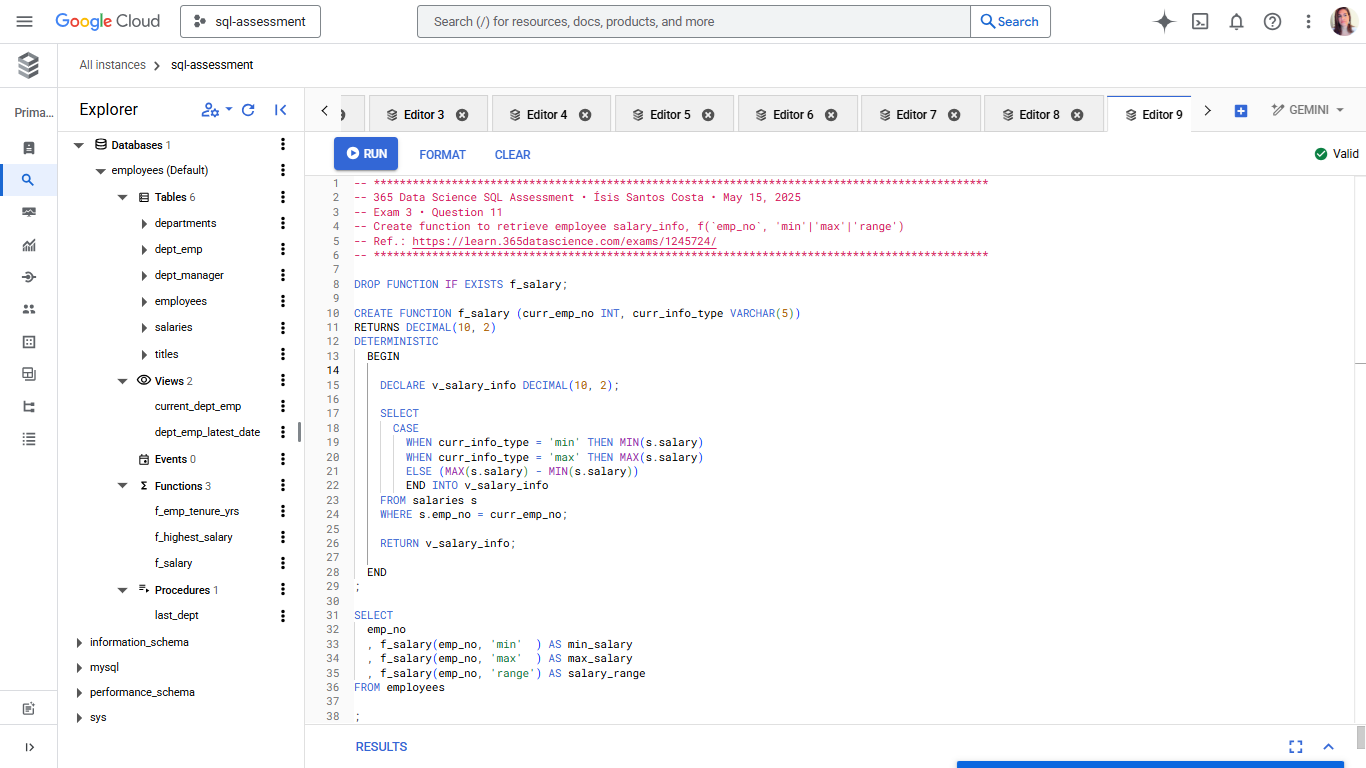

<br>

Everything was fine by the completion of the planned tasks, that had then cost around R\\$ 7 (approximately **\\$ 1.24** at today's exchange rate).  

The related MySQL instance, however, was unnecessarily left running, leading to unecessary costs, almost 10xing the total bill to **\\$ 10**, fortunately a reasonable amount, as the issue was found out in just two days, given the fact that my bookmark to GCP is for the billing section. 😮‍💨

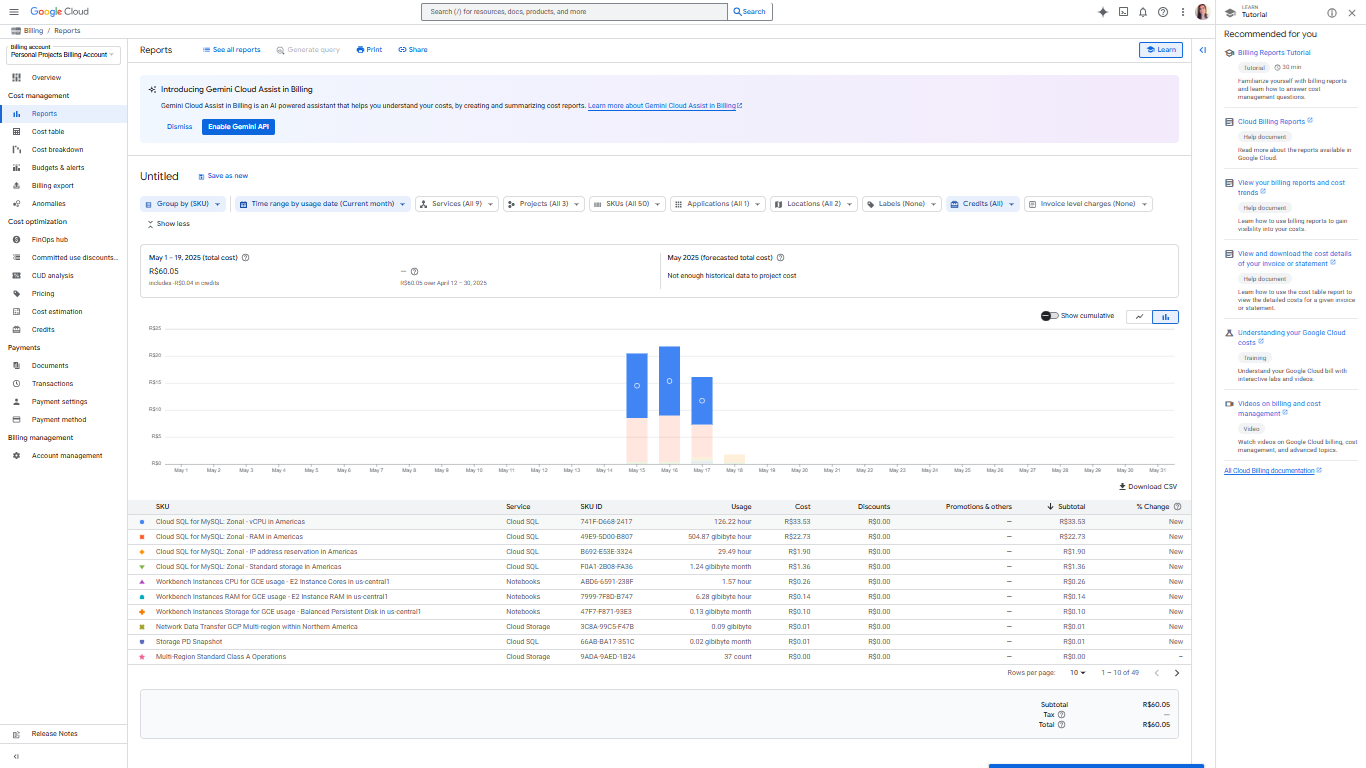

<a id='takeaways'></a>
<div style="border: 2px solid #090088; border-radius: 10px;">
    <p style="font-size:26px; text-align:justify; padding-top: 10px; padding-left: 25px; padding-right: 25px; margin-bottom:-0.5em;">
        <strong>Takeaways</strong>
    </p>
  <p style="text-align:justify; padding: 25px; margin-bottom:-3em;">
      This notebook focused on answering: <br>
      <font style="font-style:italic;">
          « <strong>How to create a database from a .sql file</strong>? »</font></p>
      <ul style="text-align:justify; padding: 38px; margin-top:-1em;">
          <li>
          <strong>SQLite</strong>, world's most used database engine, was chosen for creating a database from its DDL
          </li>
          <li>
          First, the <code>sqlite3</code> module was used to <a href='#create'><strong>turn SQL DDL code into a database</strong></a>, a <code>.db</code> file
          </li>
          <li>
          Then, it was applied in <a href='#export'>exporting</a> all the database tables as a set of <code>.csv</code> files
          </li><br>
          <li>
          The output data is available on the <a href='https://www.kaggle.com/datasets/isissantoscosta/365ds-practice-exams-people-analytics-dataset'>🎓 365DS Practice Exams • People Analytics Dataset</a>
          </li>
          <li>
          It is applied in the <a href='https://www.kaggle.com/code/isissantoscosta/365ds-practice-exams-sql/'>🎓 365DS Practice Exams • SQL</a> notebook
          </li>
      </ul>
    <p style="text-align:justify; padding: 25px; margin-top:-3.5em; margin-bottom:-3em;">
        <a href='#remember' style="text-decoration:underline;">⚠️ Remember to <code>STOP</code> your cloud instances</p></a>
  </p>
  <p style="font-size:26px; text-align:right; padding-right:25px; 
      margin-top:-2.5em; margin-bottom:0em;">
      <a href='#top' style="text-decoration:none;"><strong>↑</strong></a></p>
</div>

<h6 style="background-color:#03002e; padding:12px; border-radius:8px; color:white; text-align:center; font-weight:bold; font-size:150%; font-style:normal;">
    <strong>See you on the next coding!</strong><br>
    <font style='font-size:55%; font-weight:thin; font-style:italic;'>(yours or mine) (or ours!)</font>
</h6>